<a href="https://colab.research.google.com/github/RylieWeaver/NLP/blob/main/NLP_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9.4 Lab Assignment #5: Topic Modeling

https://colab.research.google.com/drive/19y5rpwGVqT9Gbvom9mM4YMWWXbctBkW4?usp=sharing

## Setup

### Mount Drive

In [ ]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
# Travel to NLP Directory
%cd "/content/drive/MyDrive/CGU/NLP"

/content/drive/MyDrive/CGU/NLP


In [ ]:
%ls

Lab1/  Lab2/  Lab3/  Lab3.2/  Lab3.2_extra/  Lab3_extra/  Lab4/  Lab4_extra/  Lab5/  Lab5_extra/


### Pip

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.6 MB/s eta 0:00:00


### Imports

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import re
import ast
import pickle

In [ ]:
import gensim
from gensim import corpora
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

In [ ]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
from gensim.models import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Clean Data



### Load

In [ ]:
reviews = pd.read_csv('Lab3_extra/csv_files/cleaned_reviews.csv')

In [ ]:
reviews.head()

,Rating,Date,Review,Business,City,State,Zip,Business Rating Score,Cleaned Review
0,5.0,2008-09-29 09:33:04,its the best pizza hut i'v found in florida al...,Pizza Hut,Orlando,FL,32819,3.5,its the best pizza hut find florida always get...
1,3.0,2013-12-06 23:22:26,"This place is an interesting combo. The chef, ...",La Mongerie Bakery & Bistro,Atlanta,GA,30308,3.0,this place interesting combo the chef david in...
2,5.0,2008-11-16 09:44:04,Pizza Hut is great! You get huge pizzas for yo...,Pizza Hut,Orlando,FL,32819,3.5,pizza hut great you get huge pizza for your mo...
3,5.0,2016-04-11 17:00:34,Always a great place to taste some tea with fr...,Teavana,Atlanta,GA,30326,3.0,always great place taste some tea with friend ...
4,4.0,2015-05-26 06:47:56,Delish! Stopped in on a random Sunday and so g...,Native Foods Cafe,Happy Valley,OR,97086,4.5,delish stopped random sunday and glad normally...


In [ ]:
reviews.shape

(63213, 9)

### Tokenize

(because I translated from tokens to string in lab3)

In [ ]:
def tokenize(text):
  tokenized = word_tokenize(text)
  return tokenized

In [ ]:
# Test the tokenization
column = reviews['Cleaned Review']
test = column[10]
print(test)
print("----------------------------------------------------------------------")
print(tokenize(test))

shame for take long get here walk notice sign say sue say already like this place woman take order ask she the famous sue she say sue but not not famous get hot italian perfect like the bun little toasted not get soggy with the oil will back
----------------------------------------------------------------------
['shame', 'for', 'take', 'long', 'get', 'here', 'walk', 'notice', 'sign', 'say', 'sue', 'say', 'already', 'like', 'this', 'place', 'woman', 'take', 'order', 'ask', 'she', 'the', 'famous', 'sue', 'she', 'say', 'sue', 'but', 'not', 'not', 'famous', 'get', 'hot', 'italian', 'perfect', 'like', 'the', 'bun', 'little', 'toasted', 'not', 'get', 'soggy', 'with', 'the', 'oil', 'will', 'back']


In [ ]:
# Apply tokenization to the DataFrame
reviews['Cleaned Review'] = reviews['Cleaned Review'].apply(tokenize)

In [ ]:
# Check tokenization
reviews.head()

,Rating,Date,Review,Business,City,State,Zip,Business Rating Score,Cleaned Review
0,5.0,2008-09-29 09:33:04,its the best pizza hut i'v found in florida al...,Pizza Hut,Orlando,FL,32819,3.5,"[its, the, best, pizza, hut, find, florida, al..."
1,3.0,2013-12-06 23:22:26,"This place is an interesting combo. The chef, ...",La Mongerie Bakery & Bistro,Atlanta,GA,30308,3.0,"[this, place, interesting, combo, the, chef, d..."
2,5.0,2008-11-16 09:44:04,Pizza Hut is great! You get huge pizzas for yo...,Pizza Hut,Orlando,FL,32819,3.5,"[pizza, hut, great, you, get, huge, pizza, for..."
3,5.0,2016-04-11 17:00:34,Always a great place to taste some tea with fr...,Teavana,Atlanta,GA,30326,3.0,"[always, great, place, taste, some, tea, with,..."
4,4.0,2015-05-26 06:47:56,Delish! Stopped in on a random Sunday and so g...,Native Foods Cafe,Happy Valley,OR,97086,4.5,"[delish, stopped, random, sunday, and, glad, n..."


### Normalize

(make sure removed digits and punctuation)

In [ ]:
def normalize_tokens(tokens):
  normalized_tokens = []

  for token in tokens:
      if isinstance(token, str):

        # Remove digits and punctuation
        token = re.sub(r'[\d\W]+', '', token)

        # Append the token
        normalized_tokens.append(token)

  return normalized_tokens

In [ ]:
# Test the normalization
column = reviews['Cleaned Review']
test = column[10]
print(test)
print("----------------------------------------------------------------------")
print(normalize_tokens(test))

['shame', 'for', 'take', 'long', 'get', 'here', 'walk', 'notice', 'sign', 'say', 'sue', 'say', 'already', 'like', 'this', 'place', 'woman', 'take', 'order', 'ask', 'she', 'the', 'famous', 'sue', 'she', 'say', 'sue', 'but', 'not', 'not', 'famous', 'get', 'hot', 'italian', 'perfect', 'like', 'the', 'bun', 'little', 'toasted', 'not', 'get', 'soggy', 'with', 'the', 'oil', 'will', 'back']
----------------------------------------------------------------------
['shame', 'for', 'take', 'long', 'get', 'here', 'walk', 'notice', 'sign', 'say', 'sue', 'say', 'already', 'like', 'this', 'place', 'woman', 'take', 'order', 'ask', 'she', 'the', 'famous', 'sue', 'she', 'say', 'sue', 'but', 'not', 'not', 'famous', 'get', 'hot', 'italian', 'perfect', 'like', 'the', 'bun', 'little', 'toasted', 'not', 'get', 'soggy', 'with', 'the', 'oil', 'will', 'back']


In [ ]:
# Apply normalization to the DataFrame
reviews['Cleaned Review'] = reviews['Cleaned Review'].apply(normalize_tokens)

In [ ]:
# Check normalization
reviews.head()

,Rating,Date,Review,Business,City,State,Zip,Business Rating Score,Cleaned Review
0,5.0,2008-09-29 09:33:04,its the best pizza hut i'v found in florida al...,Pizza Hut,Orlando,FL,32819,3.5,"[its, the, best, pizza, hut, find, florida, al..."
1,3.0,2013-12-06 23:22:26,"This place is an interesting combo. The chef, ...",La Mongerie Bakery & Bistro,Atlanta,GA,30308,3.0,"[this, place, interesting, combo, the, chef, d..."
2,5.0,2008-11-16 09:44:04,Pizza Hut is great! You get huge pizzas for yo...,Pizza Hut,Orlando,FL,32819,3.5,"[pizza, hut, great, you, get, huge, pizza, for..."
3,5.0,2016-04-11 17:00:34,Always a great place to taste some tea with fr...,Teavana,Atlanta,GA,30326,3.0,"[always, great, place, taste, some, tea, with,..."
4,4.0,2015-05-26 06:47:56,Delish! Stopped in on a random Sunday and so g...,Native Foods Cafe,Happy Valley,OR,97086,4.5,"[delish, stopped, random, sunday, and, glad, n..."


### Build Corpus

In [ ]:
# Use actual reviews to make corpus
review_column = reviews['Cleaned Review']

In [ ]:
# Convert string representations of lists back to actual lists
review_column = review_column.apply(ast.literal_eval)

In [ ]:
# Check conversion
review_column.head()

0    [its, the, best, pizza, hut, find, florida, al...
1    [this, place, interesting, combo, the, chef, d...
2    [pizza, hut, great, you, get, huge, pizza, for...
3    [always, great, place, taste, some, tea, with,...
4    [delish, stopped, random, sunday, and, glad, n...
Name: Cleaned Review, dtype: object

In [ ]:
# Build the bigram model
bigram = Phrases(review_column, min_count=1, threshold=2)
bigram_mod = Phraser(bigram)

# Apply the bigram model to the reviews
bigram_reviews = [bigram_mod[review] for review in review_column]

In [ ]:
# Create a dictionary from the reviews
dictionary = corpora.Dictionary(bigram_reviews)

# Filter out words that occur less than 60 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=60, no_above=0.5)

# The final number of tokens in the dictionary
print(f"Number of unique tokens: {len(dictionary)}")

Number of unique tokens: 4440


In [ ]:
# Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples
corpus = [dictionary.doc2bow(review) for review in bigram_reviews]

In [ ]:
# Print the first few documents in the corpus
for doc in corpus[:5]:
    print(doc)
    print("---")

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3)]
---
[(16, 1), (20, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 4), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1)]
---
[(6, 1), (7, 2), (9, 2), (13, 1), (21, 2), (35, 1), (36, 1), (50, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1)]
---
[(0, 1), (6, 1), (14, 1), (54, 1), (70, 1), (80, 1), (81, 1), (82, 1), (83, 1)]
---
[(4, 1), (7, 2), (11, 1), (26, 1), (35, 1), (51, 1), (64, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1

### Save

In [ ]:
%ls

Lab1/  Lab2/  Lab3/  Lab3.2/  Lab3.2_extra/  Lab3_extra/  Lab4/  Lab4_extra/  Lab5/  Lab5_extra/


In [ ]:
# DataFrame
reviews.to_csv('Lab5/cleaned_lemma_reviews.csv', index=False)

In [ ]:
# Dictionary
with open('Lab5/dictionary.pkl', 'wb') as f:
    pickle.dump(dictionary, f)

In [ ]:
# Corpus
with open('Lab5/corpus.pkl', 'wb') as f:
    pickle.dump(corpus, f)

## LSA

### Load

In [ ]:
reviews = pd.read_csv('Lab5/cleaned_lemma_reviews.csv')

In [ ]:
reviews.head()

,Rating,Date,Review,Business,City,State,Zip,Business Rating Score,Cleaned Review
0,5.0,2008-09-29 09:33:04,its the best pizza hut i'v found in florida al...,Pizza Hut,Orlando,FL,32819,3.5,"['its', 'the', 'best', 'pizza', 'hut', 'find',..."
1,3.0,2013-12-06 23:22:26,"This place is an interesting combo. The chef, ...",La Mongerie Bakery & Bistro,Atlanta,GA,30308,3.0,"['this', 'place', 'interesting', 'combo', 'the..."
2,5.0,2008-11-16 09:44:04,Pizza Hut is great! You get huge pizzas for yo...,Pizza Hut,Orlando,FL,32819,3.5,"['pizza', 'hut', 'great', 'you', 'get', 'huge'..."
3,5.0,2016-04-11 17:00:34,Always a great place to taste some tea with fr...,Teavana,Atlanta,GA,30326,3.0,"['always', 'great', 'place', 'taste', 'some', ..."
4,4.0,2015-05-26 06:47:56,Delish! Stopped in on a random Sunday and so g...,Native Foods Cafe,Happy Valley,OR,97086,4.5,"['delish', 'stopped', 'random', 'sunday', 'and..."


In [ ]:
reviews.shape

(63213, 9)

In [ ]:
# Dictionary
with open('Lab5/dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)

In [ ]:
# Print first 10 entries of the dictionary
for i, word in enumerate(dictionary.iteritems()):
    print(word)
    if i == 9: break  # Only show first 10 words

print(f"Total number of unique tokens: {len(dictionary)}")

(0, 'always')
(1, 'child')
(2, 'feel')
(3, 'feel_welcome')
(4, 'find')
(5, 'florida')
(6, 'friendly')
(7, 'get')
(8, 'great_deal')
(9, 'huge')
Total number of unique tokens: 4440


In [ ]:
# Corpus
with open('Lab5/corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)

In [ ]:
# Print the first document in the corpus
first_doc = [(dictionary[word_id], count) for word_id, count in corpus[0]]
print(first_doc)

print(f"Total number of documents: {len(corpus)}")

[('always', 1), ('child', 1), ('feel', 1), ('feel_welcome', 1), ('find', 1), ('florida', 1), ('friendly', 1), ('get', 1), ('great_deal', 1), ('huge', 1), ('its', 1), ('make', 2), ('offer', 1), ('pizza_hut', 1), ('staff_very', 1), ('the_best', 1), ('them', 2), ('they', 1), ('way_too', 1), ('welcome', 1), ('with', 1), ('you', 3)]
Total number of documents: 63213


### Shared

In [ ]:
# Function to train LSA model and compute coherence score
def evaluate_models(corpus, dictionary, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=[[dictionary[word_id] for word_id, _ in doc] for doc in corpus], dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
def plot_coherence_scores(start, limit, step, coherence_values, title):
    x = range(start, limit + 1, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.title(title)
    plt.show()

In [ ]:
# Function to re-train LSA model with a new number of topics and evaluate coherence
def retrain_evaluate_lsa(corpus, dictionary, num_topics):
    model = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
    coherencemodel = CoherenceModel(model=model, texts=[[dictionary[word_id] for word_id, _ in doc] for doc in corpus], dictionary=dictionary, coherence='c_v')
    coherence_score = coherencemodel.get_coherence()
    return model, coherence_score

### BOW

**Implementation**

In [ ]:
# Evaluate Models
bow_model_list, bow_coherence_values = evaluate_models(corpus, dictionary, 2, 10, 2)

In [ ]:
# Combine coherence scores with model indices
coherence_with_indices = list(zip(bow_coherence_values, range(len(bow_coherence_values))))

# Sort by coherence score in descending order
sorted_by_coherence = sorted(coherence_with_indices, key=lambda x: x[0], reverse=True)

# Extract indices of the top three models
top_three_indices = [index for _, index in sorted_by_coherence[:3]]

# Print details of the top three models
print("Top 3 BoW Models based on Coherence Scores:")
for rank, model_index in enumerate(top_three_indices, start=1):
    model = bow_model_list[model_index]
    coherence_score = bow_coherence_values[model_index]
    num_topics = 2 + 2*model_index  # Based on your step size and start value
    print(f"Rank {rank}: Model with {num_topics} Topics, Coherence Score: {coherence_score}")

# Directly assess the top 3 models
top_three_models = [bow_model_list[i] for i in top_three_indices]

# Print topic details for the top three models
for rank, model in enumerate(top_three_models, start=1):
    print(f"\nTopics for Rank {rank} Model:")
    topics = model.show_topics(num_topics=-1, formatted=False)
    for num, topic in topics:
        topic_labels = ", ".join([word for word, _ in topic])
        print(f"Topic {num}: {topic_labels}")

Top 3 BoW Models based on Coherence Scores:
Rank 1: Model with 2 Topics, Coherence Score: 0.6251342068624874
Rank 2: Model with 10 Topics, Coherence Score: 0.5986275322784811
Rank 3: Model with 6 Topics, Coherence Score: 0.5928378527241199

Topics for Rank 1 Model:
Topic 0: that, for, but, they, with, get, you, food, this, order
Topic 1: that, for, they, food, with, good, you, great, but, service

Topics for Rank 2 Model:
Topic 0: that, for, but, they, with, get, you, food, this, order
Topic 1: that, for, they, food, with, you, good, but, great, service
Topic 2: they, that, with, this, order, food, their, get, she, for
Topic 3: you, order, for, food, but, she, your, that, our, this
Topic 4: for, but, order, good, with, you, food, that, great, she
Topic 5: food, but, you, order, for, get, they, that, this, she
Topic 6: with, food, order, that, but, good, for, this, pizza, great
Topic 7: but, food, with, get, order, that, they, great, you, pizza
Topic 8: get, this, order, with, pizza, th

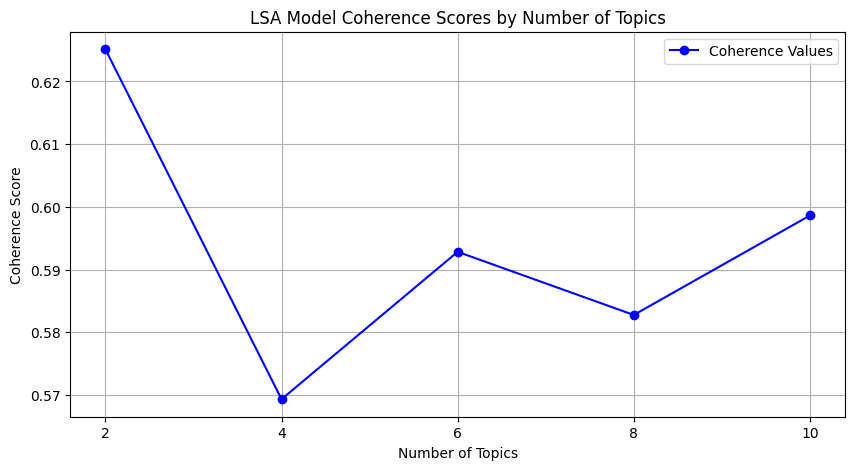

In [ ]:
# Plot to visualize num topics effect on coherence
x = range(2, 11, 2)

plt.figure(figsize=(10, 5))
plt.plot(x, bow_coherence_values, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("LSA Model Coherence Scores by Number of Topics")
plt.xticks(x)
plt.legend(["Coherence Values"], loc='best')
plt.grid(True)
plt.show()

**Experimentation**

In [ ]:
# Explore around the top 3 models
for model_index in top_three_indices:
    original_num_topics = 2 + model_index * 2  # Original calculation for number of topics

    for adjustment in [-1, 1]:  # Adjust to explore one less and one more topic
        new_num_topics = original_num_topics + adjustment
        new_model, new_coherence_score = retrain_evaluate_lsa(corpus, dictionary, new_num_topics)

        print(f"\nExplored {new_num_topics} Topics: Coherence Score = {new_coherence_score}")

        # Show top words for each topic in the new model
        topics = new_model.show_topics(num_topics=-1, formatted=False)
        for num, topic in topics:
            print(f"Topic {num}:")
            topic_words = [word for word, _ in topic]
            print(", ".join(topic_words))


Explored 1 Topics: Coherence Score = 0.6606595250307525
Topic 0:
that, for, but, they, with, get, you, food, this, order

Explored 3 Topics: Coherence Score = 0.5724564611638514
Topic 0:
that, for, but, they, with, get, you, food, this, order
Topic 1:
that, for, food, good, great, with, you, but, they, service
Topic 2:
they, that, for, with, this, order, get, their, but, she

Explored 9 Topics: Coherence Score = 0.5828939763638611
Topic 0:
that, for, but, they, with, get, you, food, this, order
Topic 1:
that, for, they, food, with, you, good, but, great, service
Topic 2:
they, that, with, this, order, food, their, get, she, for
Topic 3:
you, order, for, food, but, she, your, that, our, like
Topic 4:
for, but, order, good, with, you, food, great, that, she
Topic 5:
food, but, you, order, for, get, they, that, this, she
Topic 6:
with, food, that, order, this, for, good, but, pizza, great
Topic 7:
but, with, get, food, order, that, they, great, you, pizza
Topic 8:
this, get, with, order,

**Analysis**

Although the models with the highest coherence scores are one and two topics coherence scores of about 0.66 and 0.62, just one or two topics is unlikely to show granularity or specificity in its information. In fact, the topic words for 1 topic seem to be simply general words related to businesses, not related to specifically good or bad service.

Aside from 1 or 2 topics, 5 topics has the next highest coherence score of bout 0.60. In addition, I expect 5 topics to be sufficient enough to model a subject such as restaurant reviews.

I label the 5 topics as follows:
0.   General Complaints and Orders: Concerns and mixed feelings about dining, centered around words like "order," "get," and "but."
1.   Positive Food and Service: High satisfaction, indicated by "good," "great," "food," and "service."
2.   Specific Service Interactions: Positive narratives of staff interactions, highlighted by "they," "with," "she," and "great."
3.   Personalized Experiences: Focuses on individual experiences, with "you," "your," "order," and "but" indicating personalized feedback.
4.   Order Quality Assessments: Varied evaluations of food, featuring "order," "food," "good," and "great," showing a balance of satisfaction and nuanced critique.

This model sorts restaurant reviews into five clear topics, reflecting common threads in customer feedback. It covers areas from general service concerns and positive acknowledgments of food and service quality, to accounts of interactions with staff, personalized dining experiences, and varied reactions to food orders. It could serve as a useful tool for restaurant owners to grasp what customers appreciate and what might need improvement.

### Tf-idf

In [ ]:
from gensim.models import TfidfModel

# Generate a TF-IDF model based on the BoW corpus
tfidf_model = TfidfModel(corpus)
tfidf_corpus = [tfidf_model[doc] for doc in corpus]

**Implementation**

In [ ]:
# Evaluate Models
tfidf_model_list, tfidf_coherence_values = evaluate_models(tfidf_corpus, dictionary, 2, 10, 2)

In [ ]:
# Combine coherence scores with model indices for TF-IDF
coherence_with_indices_tfidf = list(zip(tfidf_coherence_values, range(len(tfidf_coherence_values))))

# Sort by coherence score in descending order for TF-IDF
sorted_by_coherence_tfidf = sorted(coherence_with_indices_tfidf, key=lambda x: x[0], reverse=True)

# Extract indices of the top three models for TF-IDF
top_three_indices_tfidf = [index for _, index in sorted_by_coherence_tfidf[:3]]

# Print details of the top three TF-IDF models
print("Top 3 TF-IDF Models based on Coherence Scores:")
for rank, model_index in enumerate(top_three_indices_tfidf, start=1):
    model = tfidf_model_list[model_index]
    coherence_score = tfidf_coherence_values[model_index]
    num_topics = 2 + 2*model_index  # Adjusted based on your step size and start value
    print(f"Rank {rank}: Model with {num_topics} Topics, Coherence Score: {coherence_score}")

# Directly assess the top 3 models
top_three_models = [bow_model_list[i] for i in top_three_indices]

# Print topic details for the top three models
for rank, model in enumerate(top_three_models, start=1):
    print(f"\nTopics for Rank {rank} Model:")
    topics = model.show_topics(num_topics=-1, formatted=False)
    for num, topic in topics:
        topic_labels = ", ".join([word for word, _ in topic])
        print(f"Topic {num}: {topic_labels}")

Top 3 TF-IDF Models based on Coherence Scores:
Rank 1: Model with 2 Topics, Coherence Score: 0.6046934158337754
Rank 2: Model with 6 Topics, Coherence Score: 0.5087757943656954
Rank 3: Model with 4 Topics, Coherence Score: 0.4839443205736357

Topics for Rank 1 Model:
Topic 0: that, for, but, they, with, get, you, food, this, order
Topic 1: that, for, they, food, with, good, you, great, but, service

Topics for Rank 2 Model:
Topic 0: that, for, but, they, with, get, you, food, this, order
Topic 1: that, for, they, food, with, you, good, but, great, service
Topic 2: they, that, with, this, order, food, their, get, she, for
Topic 3: you, order, for, food, but, she, your, that, our, this
Topic 4: for, but, order, good, with, you, food, that, great, she
Topic 5: food, but, you, order, for, get, they, that, this, she
Topic 6: with, food, order, that, but, good, for, this, pizza, great
Topic 7: but, food, with, get, order, that, they, great, you, pizza
Topic 8: get, this, order, with, pizza, 

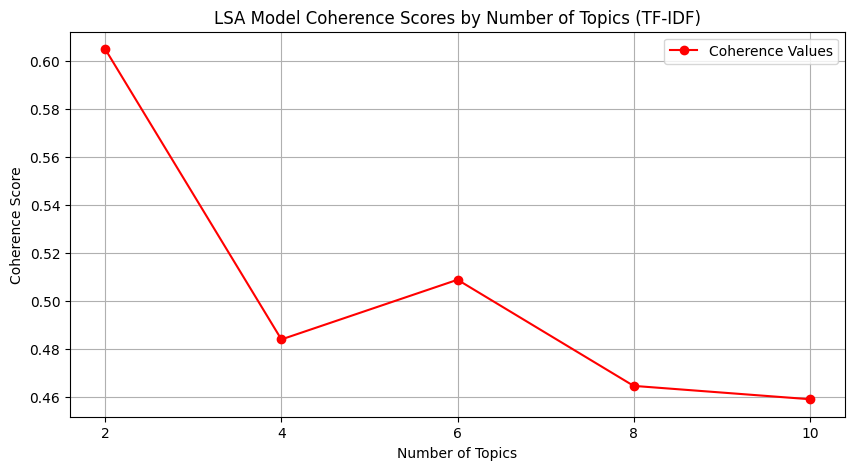

In [ ]:
# Plotting for TF-IDF models
x = range(2, 11, 2)
plt.figure(figsize=(10, 5))
plt.plot(x, tfidf_coherence_values, marker='o', linestyle='-', color='r')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("LSA Model Coherence Scores by Number of Topics (TF-IDF)")
plt.xticks(x)
plt.legend(["Coherence Values"], loc='best')
plt.grid(True)
plt.show()

**Experimentation**

In [ ]:
# Exploring around the top 3 models with TF-IDF
for model_index in top_three_indices_tfidf:
    original_num_topics = 2 + model_index * 2

    for adjustment in [-1, 1]:
        new_num_topics = original_num_topics + adjustment
        new_model, new_coherence_score = retrain_evaluate_lsa(tfidf_corpus, dictionary, new_num_topics)

        print(f"\nExplored {new_num_topics} Topics (TF-IDF): Coherence Score = {new_coherence_score}")

        topics = new_model.show_topics(num_topics=-1, formatted=False)
        for num, topic in topics:
            topic_words = ", ".join([word for word, _ in topic])
            print(f"Topic {num}: {topic_words}")


Explored 1 Topics (TF-IDF): Coherence Score = 0.6484663860215972
Topic 0: that, they, you, for, but, food, order, get, with, good

Explored 3 Topics (TF-IDF): Coherence Score = 0.495176881740289
Topic 0: that, they, you, for, but, food, order, get, with, good
Topic 1: pizza, crust, food, delivery, topping, cheese, order, slice, sushi, great
Topic 2: great, she, delicious, pizza, order, the_best, love, good, place, awesome

Explored 5 Topics (TF-IDF): Coherence Score = 0.46411994589951766
Topic 0: that, they, you, for, but, food, order, get, with, good
Topic 1: pizza, crust, food, delivery, topping, cheese, slice, sushi, order, sub
Topic 2: great, she, delicious, order, pizza, the_best, love, good, place, awesome
Topic 3: great, chicken, service, food, sandwich, she, drink, bar, sauce, rice
Topic 4: burger, fry, you, chicken, she, sandwich, sushi, rice, order, food

Explored 7 Topics (TF-IDF): Coherence Score = 0.48623193977025203
Topic 0: that, they, you, for, but, food, order, get, w

Although the models with the highest coherence scores are one and two topics coherence scores of about 0.64 and 0.61, just one or two topics is unlikely to show granularity or specificity in its information. In fact, the topic words for 1 topic seem to be simply general words related to businesses, not related to specificaly good or bad service.

Aside from 1 or 2 topics, 6 topics has the next highest coherence score of about 0.51. In addition, I expect 6 topics to be sufficient enough to model a subject such as restaurant reviews.

I label the 6 topics as follows:
0.   General Dining Feedback. Covers broad aspects of dining experiences, focusing on the ordering process and overall interactions, indicating a mix of sentiments.
1.   Positive Dining Experiences. Highlights satisfaction with food and service, using positive descriptors like "good" and "great," suggesting favorable reviews.
2.   Staff Interactions and Orders. Details interactions with restaurant staff ("she," "their") and the ordering process.
3. Personal Order Experiences. Focuses on individual ordering experiences ("your," "you") and specific mentions of food, indicating personal feedback on service and meals.
4. Quality of Food and Service. Emphasizes the quality of food and service, with a positive outlook ("good," "great"), reflecting commendations on dining experiences.
5.   Mixed Reviews on Orders. Captures mixed feelings about food orders, with a balance of positive and negative nuances, indicating varied customer experiences.

The 6 topics outlined in the model offer a look into the restaurant review subject, spanning from general observations on dining to specific aspects of service and food quality. Such a model could be very valuable to restaurant owners.

## LDA

### Make Dictionary/Corpus

In [ ]:
# Make bigrams
bigram_phrases = Phrases(review_column, min_count=5, threshold=10)
bigram = Phraser(bigram_phrases)
bigram_reviews = [bigram[review] for review in review_column]

In [ ]:
# Create a dictionary representation of the documents
dictionary = Dictionary(bigram_reviews)

# Filter out extremes to remove noise
dictionary.filter_extremes(no_below=5, no_above=0.5)

# The final number of tokens in the dictionary
print(f"Number of unique tokens: {len(dictionary)}")

Number of unique tokens: 19760


In [ ]:
# Convert document into the BOW format
corpus = [dictionary.doc2bow(review) for review in bigram_reviews]

### Implement

In [ ]:
# Compute coherence function
def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                             chunksize=1500, passes=20, iterations=400,
                             eval_every=None, random_state=100,
                             alpha='auto', eta='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Evaluate Models
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=bigram_reviews, start=4, step=2, limit=18)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Select the model with the highest coherence score
best_score = max(coherence_values)
best_index = coherence_values.index(best_score)
best_lda_model = model_list[best_index]

# Print the selected model's details
print(f"Best Model: {best_index + 4} Topics, Coherence Score: {best_score}")

Best Model: 6 Topics, Coherence Score: 0.43407524316302704


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Prepare the visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_model, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
# Print the selected model's details
print(f"Best Model: {best_index + 4} Topics, Coherence Score: {best_score}")

# Printing topics from the best model
topics = best_lda_model.show_topics(num_topics=-1, formatted=True)
for topic in topics:
    print(topic)

Best Model: 6 Topics, Coherence Score: 0.43407524316302704
(0, '0.065*"order" + 0.033*"our" + 0.026*"she" + 0.024*"wait" + 0.020*"ask" + 0.019*"say" + 0.019*"take" + 0.017*"after" + 0.014*"food" + 0.014*"tell"')
(1, '0.036*"with" + 0.029*"drink" + 0.027*"bar" + 0.019*"coffee" + 0.013*"beer" + 0.010*"friend" + 0.010*"night" + 0.009*"table" + 0.009*"room" + 0.008*"tea"')
(2, '0.056*"salad" + 0.055*"sandwich" + 0.023*"bread" + 0.016*"egg" + 0.012*"wrap" + 0.010*"pasta" + 0.010*"healthy" + 0.009*"toast" + 0.008*"italian" + 0.008*"juice"')
(3, '0.077*"pizza" + 0.048*"fry" + 0.038*"cheese" + 0.032*"burger" + 0.021*"wing" + 0.019*"steak" + 0.016*"slice" + 0.014*"order" + 0.013*"side" + 0.012*"sauce"')
(4, '0.041*"with" + 0.035*"chicken" + 0.021*"dish" + 0.019*"sauce" + 0.019*"taste" + 0.019*"flavor" + 0.014*"rice" + 0.014*"meat" + 0.012*"order" + 0.012*"spicy"')
(5, '0.034*"that" + 0.032*"they" + 0.030*"but" + 0.028*"you" + 0.019*"get" + 0.015*"there" + 0.012*"just" + 0.012*"with" + 0.012*"on

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Analysis**

With a coherence score of about 0.43, the best model includes 6 topics.

0.   Service and Waiting Experience: Dominated by words like "order," "wait," "ask," "say," indicating discussions around the service timeline and staff interactions.
1.   Drinks and Social Setting: Including "drink," "bar," "coffee," "beer," "friend," "night," suggesting a focus on the drinking experience and social aspects of dining.
2.   Healthy Meal Choices: With "salad," "sandwich," "bread," "egg," "wrap," "pasta," "healthy," indicating preferences for lighter, possibly healthier food options.
3.   Comfort and Fast Foods: Centered around "pizza," "fry," "cheese," "burger," "wing," "steak," focusing on popular comfort and fast food items.
4.   Flavorful Dishes: Key words "chicken," "dish," "sauce," "taste," "flavor," "rice," "spicy," point to a variety of flavorful and possibly ethnic dishes.
5.   General Customer Feedback: Uses general terms like "that," "they," "but," "you," "get," reflecting a broad range of customer feedback without a specific focus.
6. Positive Restaurant Experiences. Including "food," "good," "place," "great," "service," "love," "delicious," indicating overall positive dining experiences.
7.   Specialty and Desserts: Foods such as "sushi," "roll," "ice cream," "cake," "fish," "salmon," highlighting a preference for specialty dishes and desserts.

These labels and justifications are directly derived from the significant words in each topic, aiming to capture the essence of discussions within restaurant reviews. There are multiple topics dedicated to different types of foods, indicating varied food categories in the reviews and LDA's ability to identify them. Topics also include the common restaurant subjects one might expect of wait staff, social setting, and general restaurant experience.

## Analysis

Upon examining the best model from LSA-BOW, LSA-tfIdf, and LDA, I select LSA_BOW as the best model because it has the best coherence score. Additionally, although the LDA model has low coherence, I give it an honorable mention for the wide spread represented in its topics.

As we might expect, general restaurant experience, wait staff, and social setting are major factors in topics. Interestingly, LDA also picks up on food types as major topics as well. These topics outline the most important factors related to the restaurant business, and could prove very valuable to future business operations for interested parties.